In [1]:
using Plots
using QuadGK
using NLopt
using SpecialFunctions
using NLsolve
using Statistics
using Measures
include("../../scaling_CGS.jl")

print_all_CGS (generic function with 2 methods)

In [2]:
#---------- Two Steam Setup ----------
base = BaseUnits("CGS")

electron_mass_scaling = 1e0
charge_scaling = 1e0
eps_0_scaling = 1e0
mu_0_scaling = 1e0

scale_base_units(base, eps_0_scaling, mu_0_scaling, electron_mass_scaling, charge_scaling)

mass_density_scale = 1.673532836356e-14
#length_scale       = 227.71078654314857#ion skin depth
length_scale       = 5.314093711399421 # electron skin depth
#time_scale         = 1.1137516851221212e-9 # here omega_e = 2pi in code units -> means 1 plasma oscillation is 1 code unit
time_scale         = 1.7725908606411373e-10 # here omega_e=1 in code units -> means 1 plasma oscillation is 2pi code unit


#length= 227.71078654314857 #ion skin depth
length = 5.314093711399421 # electron skin depth
number_density=1e10
B_flux=10
temperature   = 592989.85 # Corresponds to v_t_e = 0.01*c  = 0.05*V_0
#temperature   = 2.3719594179263036e6 # Corresponds to v_t_e = 0.1*V_0  for V_0 = 0.2*c 
#temperature   = 2.3719594179263036e6 * 2.0^2

temperature_e = temperature
temperature_p = temperature



scaling = ScalingCGS(base,
                number_density, length, temperature, temperature_e, temperature_p, B_flux,
                length_scale, mass_density_scale, time_scale)

ds = 0.0025
per_cell = 125

set_macro_particle_weights(scaling, ds, per_cell);
print_all_CGS(scaling)


 Maxwell Lorents Factors used in code:
 k_E =                                             =  1.0000e+00 


 k_B =                                             =  1.0000e+00 
 k_F =                                             =  1.0000e+00 
 k_D =                                             =  1.0000e+00 
 k_M =                                             =  1.0000e+00 
 k_H =                                             =  1.0000e+00 

 Macro particle weights:
                          ds =                     =  2.5000e-03 
                    per_cell =                     =  1.2500e+02 
               weight_scaled =                     =  1.8758e+02 
 weight_scaled_mass_electron =                     =  6.8040e-14 
   weight_scaled_mass_proton =                     =  1.2493e-10 
        weight_scaled_charge =                     =  8.2268e-13 
                 rho_n_ratio =                     =  1.5007e+12 

 Fundamental physical constants:


        Gravitational Constant [ cm^3 g^-1 s^-2 ]  =  6.6743e-08  1.9017e+33  3.5096e-41
          Boltzmann's Constant [ erg K^-1 ]        =  1.3806e-16  2.2572e+09  6.1167e-26
             Planck's Constant [ erg s ]           =  6.6261e-27  4.0010e-01  1.6561e-26
              Atomic Mass Unit [ g ]               =  1.6605e-24  2.5114e-12  6.6119e-13
                   Proton Mass [ g ]               =  1.6726e-24  2.5114e-12  6.6600e-13
                 Electron Mass [ g ]               =  9.1094e-28  2.5114e-12  3.6272e-16
             Elementary Charge [ StatC ]           =  4.8032e-10  1.0952e+05  4.3857e-15
           Vacuum Permittivity [ ]                 =  1.1127e-21  1.1127e-21  1.0000e+00
           Vacuum Permeability [ s^2 cm^-2 ]       =  1.0000e+00  1.0000e+00  1.0000e+00
                Speed of Light [ cm/s ]            =  2.9979e+10  2.9979e+10  1.0000e+00
                 Electron Volt [ erg ]             =  1.6022e-12  2.2572e+09  7.0982e-22
         Mean molecul

In [4]:
c = scaling.c_code


m_i = scaling.m_p_code
m_e = scaling.m_e_code


t = scaling.temperature_code


n_i = scaling.number_density_code
n_e = scaling.number_density_code

k_B = scaling.k_B_code

V_0 = scaling.c_code * 0.2

v_t_e = scaling.v_thermal_e_code
v_t_p = scaling.v_thermal_p_code


omega_e = scaling.electron_plasma_freq_code
omega_p = scaling.proton_plasma_freq_code

debye_e = scaling.debye_len_code
debye_i = scaling.v_thermal_p_code / scaling.proton_plasma_freq_code


skin_depth = scaling.skin_depth_p_code

println(v_t_e / V_0)

0.049999999811060174


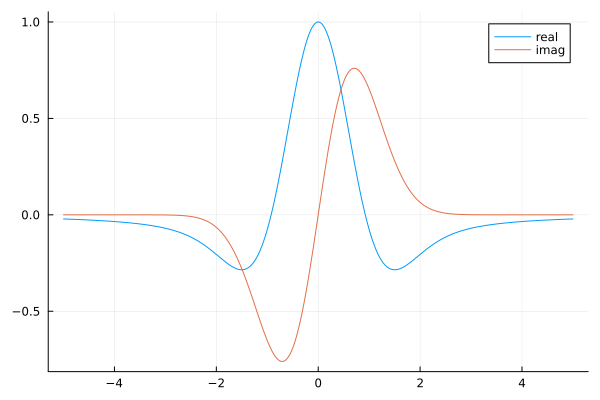

In [5]:
function W_val(z)
    #TODO Add special cases for small and large z???
    return 1. + 1im * z * sqrt(pi) * faddeeva(z)
end


function dW_dz(z)
    #TODO 
    #return 2im / sqrt(pi) - 2. *exp(-z^2) * z * erfc(- 1im * z)
    #return 2im / sqrt(pi) - 2. * z * faddeeva(z)
    #return 1im * z * sqrt(pi) * (2im / sqrt(pi) - 2. * z * faddeeva(z)) + 1im * sqrt(pi) * faddeeva(z)
    return 1im * sqrt(pi) * faddeeva(z) * (1 - 2*  z^2) - 2 * z
end

#------- to verify this is implemented correctly --------------------
#z_vals  = collect(range(-5,stop=5, length=10000))  #.+ 1.0im
z_vals  = collect(range(-5.0,stop=5.0, length=10000))  #.+ 1.0im
W_res = W_val.(z_vals);

dW_res = dW_dz.(z_vals)

plot(real.(z_vals), real.(W_res),label="real")
plot!(real.(z_vals), imag.(W_res),label="imag")
#---------------------------------------------------------------


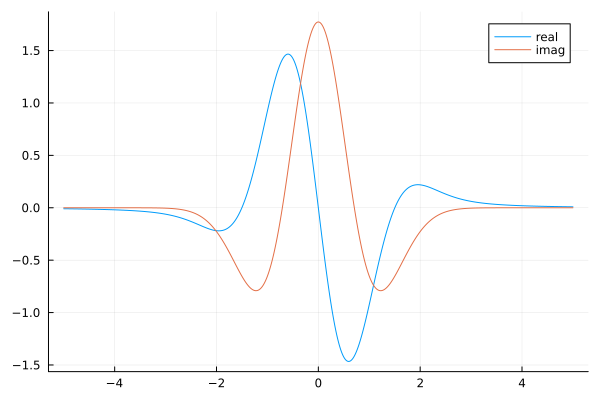

In [6]:
dW_res = dW_dz.(z_vals)

plot(real.(z_vals), real.(dW_res),label="real")
plot!(real.(z_vals), imag.(dW_res),label="imag")

In [7]:
#TODO we may rewrite all the eqautions so that omega_e refers to the frequency of each beam and not the total plasma frequency
#   This will allow us to write all the equations without the factor "1/2" in front of the electron terms
#   In general, it will allow us to built general two-stream dispersion relations

"
    full_dispertion_relation

compute the full dispersion relation for the warm electron-proton case
"
function full_dispertion_relation(omega, k, V0, v_t_e, v_t_i, debye_e, debye_i)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)
    z_0     = (omega / k )     / (sqrt(2.) * v_t_i)
    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_plus)
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_minus)
    ion_part        = 1.0 / ( debye_i * k )^2.0           * W_val(z_0)
    #TODO Make sure there is no factor sqrt(2) hiding somewhere 
    return 1. + electorn_part_1 + electorn_part_2 + ion_part
end

function full_dispertion_relation_derivative(omega, k, V0, v_t_e, v_t_i, debye_e, debye_i)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)
    z_0     = (omega / k )     / (sqrt(2.) * v_t_i)

    extra_deriv_term_elec = (1.0 / k ) / (sqrt(2.) * v_t_e)
    extra_deriv_term_prot = (1.0 / k ) / (sqrt(2.) * v_t_e)

    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * dW_dz(z_plus)  * extra_deriv_term_elec
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * dW_dz(z_minus) * extra_deriv_term_elec
    ion_part        = 1.0 / ( debye_i * k )^2.0           * dW_dz(z_0) * extra_deriv_term_prot
    #TODO Make sure there is no factor sqrt(2) hiding somewhere 
    return electorn_part_1 + electorn_part_2 + ion_part
end
"
    warm_elec_dispertion

compute the warm dispersion relation for the warm electron only case
"
function warm_elec_dispertion(omega, k, V0, v_t_e, debye_e)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)
    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_plus)
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * W_val(z_minus)
    return 1. + electorn_part_1 + electorn_part_2
end

function warm_elec_dispertion_derivative(omega, k, V0, v_t_e, debye_e)
    z_plus  = (omega / k + V0) / (sqrt(2.) * v_t_e)
    z_minus = (omega / k - V0) / (sqrt(2.) * v_t_e)

    extra_deriv_term = (1.0 / k ) / (sqrt(2.) * v_t_e)
    
    electorn_part_1 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * dW_dz(z_plus)     * extra_deriv_term
    electorn_part_2 = 1.0 / ( debye_e * k )^2.0 * 1.0/2.0 * dW_dz(z_minus)    * extra_deriv_term
    return electorn_part_1 + electorn_part_2
end
"
    cold_dispertion_relation

compute the cold dispersion relation for the cold electron-proton case
"
function cold_dispertion_relation(omega, k, V0, omega_e, omega_i)
    #TODO add special case for small V0*k?
    electorn_part_1 = 1.0/2.0 * omega_e^2  * ( 1 / (omega + V0 *k)^2 )
    electorn_part_2 = 1.0/2.0 * omega_e^2  * ( 1 / (omega - V0 *k)^2 )
    ion_part        =           omega_i^2        / omega^2
    return 1 - electorn_part_1 - electorn_part_2 - ion_part
end

function cold_dispertion_relation_derivative(omega, k, V0, omega_e, omega_i)
    #TODO add special case for small V0*k?
    electorn_part_1 =     omega_e^2  * ( 1 / (omega + V0 *k)^3 )
    electorn_part_2 =     omega_e^2  * ( 1 / (omega - V0 *k)^3 )
    ion_part        = 2*  omega_i^2        / omega^3
    return electorn_part_1 + electorn_part_2 + ion_part # note the changed sign
end
"
    cold_dispertion_relation

compute the cold dispersion relation for the cold electron only case
"
function cold_elec_dispertion_relation(omega, k, V0, omega_e)
    #TODO add special case for small V0*k?
    electorn_part_1 = 1.0/2.0 * omega_e^2  * ( 1 / (omega + V0 *k)^2 )
    electorn_part_2 = 1.0/2.0 * omega_e^2  * ( 1 / (omega - V0 *k)^2 )
    return 1 - electorn_part_1 - electorn_part_2
end

function cold_elec_dispertion_relation_derivative(omega, k, V0, omega_e)
    #TODO add special case for small V0*k?
    electorn_part_1 = omega_e^2  * ( 1 / (omega + V0 *k)^3 )
    electorn_part_2 = omega_e^2  * ( 1 / (omega - V0 *k)^3 )
    return electorn_part_1 + electorn_part_2 # note the changed sign in the derivative
end

#-------- function wrappers to be used by the newton-rhapson implementation ----------------
function function_wrapper_warm_full(omega, args...)
    return full_dispertion_relation(omega, args...)
end

function function_wrapper_warm_elec(omega, args...)
    return warm_elec_dispertion(omega, args...)
end

function function_wrapper_cold_full(omega, args...)
    return cold_dispertion_relation(omega, args...)
end

function function_wrapper_cold_elec(omega, args...)
    return cold_elec_dispertion_relation(omega, args...)
end

#----------------------------------------

function_wrapper_cold_elec (generic function with 1 method)

In [8]:
function numerical_derivative_imag(f, z; h=1e-5)
    h_val = h * 1.0im
    return (f(z + h_val) - f(z - h_val)) / (2.0*h_val)
end

function numerical_derivative_real(f, z, args; h=1e-5)
    h_val = h
    return (f(z + h_val,args...) - f(z - h_val,args...)) / (2.0*h_val)
end

newton_raphson_complex_old (generic function with 1 method)

In [9]:
function newton_raphson_complex(f, initial_guess, args, df; max_iterations=100, tol=1e-8)
    z = initial_guess
    z_all = []
    res_all = []
    df_all = []
    push!(z_all, z)
    push!(res_all, f(z,args...))


    step_redution_factor = 1.0
    real_osciallation_counter = 0
    imag_osciallation_counter = 0
    last_real_direction = 0
    last_imag_direction = 0


    large_step_counter = 0
    large_step_interval = 1


    for i in 1:max_iterations
        #println(" ")
        #println("Iteration ", i )
        fz = f(z,args...)

        dfz = df(z, args...)
        push!(df_all, dfz)

        step = fz / dfz


        if abs(step) / abs(z) < 1e-4 && large_step_counter > large_step_interval
            #println("Taking large")
            step = sign(step) * abs(z) * 1e-4
        end

        #println(" step - ", step / z)

        #--------– Update value of z --------–--------–--------–
        z_new = z - step * step_redution_factor

       # z_new = real(z_new) 
        #--------–--------–--------–--------–--------–


        #------------------ Check for oscillations ------------------------------------
        real_direction = sign(real(z_new - z) + 1e-15)
        imag_direction = sign(imag(z_new - z) + 1e-15)

        if real_direction ==  -last_real_direction
            #println("real --- ", real(z_new - z)," ", real_direction, " ", last_real_direction, " ", real_osciallation_counter)
            real_osciallation_counter += 1
        else
            real_osciallation_counter = 0
        end

        if imag_direction ==  -last_imag_direction
            #println("imag --- ", imag(z_new - z), " ", imag_direction, " ", last_imag_direction, " ", imag_osciallation_counter)
            imag_osciallation_counter += 1
        else
            imag_osciallation_counter = 0
        end

        if real_osciallation_counter > 5 || imag_osciallation_counter > 5
            #println("Oscillation detected")
            step_redution_factor *= 0.9
            real_osciallation_counter = 0
            imag_osciallation_counter = 0
        end
        last_real_direction = real_direction
        last_imag_direction = imag_direction
        #------------------------------------------------------------------------



        # Check for convergence
        push!(z_all, z_new)
        push!(res_all, f(z_new,args...))

        if abs(z_new - z) < tol && abs(fz) < 1e-6
            return z_new, f(z_new, args...), "Converged after $i iterations", z_all, res_all, df_all
        end
        z = z_new


        large_step_counter += 1
        #time_since_last_large += 1
    end

    return z, f(z, args...),  "Stopped after reaching the maximum number of iterations", z_all, res_all, df_all
end


newton_raphson_complex (generic function with 1 method)

In [10]:
#----------- Calculate the analytical solution for the cold electron only case -------–-------–-------–-------–-------–-------–-------–
k_vals           = collect(range(0.1,stop=2, length=2000)) * omega_e / V_0  
#Chose k values such that k * V_0 / omega_e is in the range [0, 2]

cold_omega_1 = -sqrt.( (-sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im)
cold_omega_2 = -sqrt.( (+sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im)
cold_omega_3 =  sqrt.( (-sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im)
cold_omega_4 =  sqrt.( (+sqrt.(8. .* k_vals.^2 .* omega_e.^2 .* V_0^2 .+ omega_e^4 .+ 0.0im) .+ 2 .* k_vals.^2 .* V_0^2 .+ omega_e^2) ./ 2 .+ 0im);


k_max_index = argmax(imag.(cold_omega_3))
k_max = k_vals[k_max_index] 
omega_max = cold_omega_3[k_max_index]
omega_max_scales = omega_max / omega_e
println("K range             = ", k_vals[1], " ", k_vals[end])
println("K_max               = ", k_max)
println("k_max / 2pi         = ", k_max / (2*pi))
println("K_max * V_0 / omega_e ", k_max * V_0 / omega_e)
println("k_max analytical    = ", sqrt(3/8) * omega_e / V_0)
println("omega_max           = ", omega_max)
println("omega_max / omega_e = ", omega_max_scales)
println("Sim Length          = ", 2 * pi / k_max * 2.)

K range             = 0.5 10.0
K_max               = 3.061530765382691
k_max / 2pi         = 0.48725775473856897
K_max * V_0 / omega_e 0.6123061530765382
k_max analytical    = 3.061862178478972
omega_max           = 0.0 + 0.3535533859335106im
omega_max / omega_e = 0.0 + 0.3535533859335106im
Sim Length          = 4.104603734984312


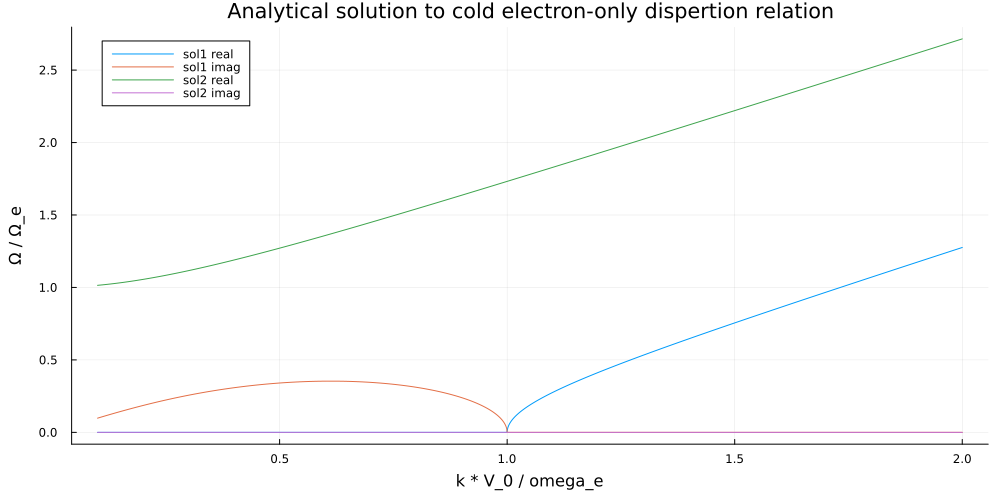

In [11]:
#-------– Plot the analytical solution for the positive omega cases -------–-------–-------–-------– 
plot(k_vals * V_0 / omega_e, real.(cold_omega_3 / omega_e), label="sol1 real", title="Analytical solution to cold electron-only dispertion relation",
    size=(1000,500), xlabel="k * V_0 / omega_e", ylabel = "Ω / Ω_e", bottom_margin=5mm, left_margin=5mm)
plot!(k_vals* V_0 / omega_e, imag.(cold_omega_3/ omega_e), label="sol1 imag")
plot!(k_vals* V_0 / omega_e, real.(cold_omega_4/ omega_e), label="sol2 real")
plot!(k_vals* V_0 / omega_e, imag.(cold_omega_4/ omega_e), label="sol2 imag")

In [12]:
cold_electron_branches = [[],[]]

for i in 1:size(k_vals,1)
    args_cold_elec = (k_vals[i], V_0, omega_e)
    res = function_wrapper_cold_elec(cold_omega_3[i], args_cold_elec...)

    if abs(res) < 1e-5
        push!(cold_electron_branches[1], ( cold_omega_3[i], k_vals[i], res))
    end 

    res = function_wrapper_cold_elec(cold_omega_4[i], args_cold_elec...)

    if abs(res) < 1e-5
        push!(cold_electron_branches[2], ( cold_omega_4[i], k_vals[i], res))
    end
end

In [88]:
function make_new_guess(branch_list, j , function_wrapper,function_deriv, args; search_type=1,  max_iterations=200, branch_step=1e-1, reversed=false)

    k = args[1]

    if reversed
        initial_guess = branch_list[j][1][1] 
    else
        initial_guess = branch_list[j][end][1]
    end


  
    
    if search_type == 1
        initial_guess = initial_guess + branch_step * omega_e
    elseif search_type == 2
        initial_guess = initial_guess - branch_step * omega_e
    elseif search_type == 3
        initial_guess = initial_guess + branch_step * omega_e * 1im
    elseif search_type == 4
        initial_guess = initial_guess - branch_step * omega_e * 1im
    end



    res0, err0, msg0 = newton_raphson_complex(function_wrapper, initial_guess, args,   function_deriv ,max_iterations=max_iterations)

    res0 = abs(real(res0)) + imag(res0) * 1im
    #if error is still too large, do not add it to the list
    if abs(err0) < 1e-5
        if (k > 10 || k < 0.5)
            println("ERROR - k out of range", k,  " intial initial_guess", initial_guess, " res ", res, " err ", err, " msg ", msg)
        end
        if reversed
            pushfirst!(branch_list[j],  (res0, k, err0))
        else
            push!(branch_list[j],  (res0, k, err0))
        end
    end

end 

make_new_guess (generic function with 1 method)

In [89]:
function make_initial_branches(function_wrap, function_deriv ,arg_static, k_vals, initial_guesses; max_iterations=200, k_cut=20.0, reversed=false)
    branch_list = [[] for i in 1:size(initial_guesses)[1]]
    
    k_size = size(k_vals)[1]
    if reversed
        k_cut = k_vals[end] - k_cut
    else
        k_cut = k_vals[1] + k_cut
    end
    cut_index = argmin(abs.(k_vals .- k_cut))

    #println("cut_index ", cut_index)


    if reversed
        for j in 1:size(initial_guesses)[1]

            i = size(initial_guesses[j],1)
            k = initial_guesses[j][i][2]

            while k > k_cut && i >= 1
                args = (k, arg_static...)
                initial_guess = initial_guesses[j][i][1]
                res, err, msg = newton_raphson_complex(function_wrap, initial_guess, args,   function_deriv ,max_iterations=max_iterations)

                if abs(err) < 1e-5
                    if (k > 10 || k < 0.5)
                        println("ERROR - k out of range", k,  " intial initial_guess", initial_guess, " res ", res, " err ", err, " msg ", msg)
                    end
                    pushfirst!(branch_list[j],  (res, k, err))
                end

                i -= 1
                if i >= 1
                    k = initial_guesses[j][i][2]
                end
            end
        end

    else
        for j in 1:size(initial_guesses)[1]

            i = 1
            k = initial_guesses[j][i][2]

            while k < k_cut && i <= size(initial_guesses[j],1)
                args = (k, arg_static...)
                initial_guess = initial_guesses[j][i][1]
                res, err, msg = newton_raphson_complex(function_wrap, initial_guess, args,   function_deriv ,max_iterations=max_iterations)

                if abs(err) < 1e-5
                    if (k > 10 || k < 0.5)
                        println("ERROR - k out of range", k,  " intial initial_guess", initial_guess, " res ", res, " err ", err, " msg ", msg)
                    end
                    push!(branch_list[j],  (res, k, err))
                end

                i += 1
                if i <= size(initial_guesses[j],1)
                    k = initial_guesses[j][i][2]
                end
            end
        end
    end

    return branch_list, cut_index
end

make_initial_branches (generic function with 1 method)

In [79]:
function find_branch_solutions(function_wrap, function_deriv ,arg_static, k_vals, initial_guesses; search_type=1, max_iterations=200, branch_step=1e-1, k_cut=20.0, large_k_diff_remove=5.0)
    k_size = size(k_vals)[1]

    

    combined_branch_list = []

    #-------- first make a gueses using the previous as inital guess for all branches ----------
   # println("intial guess ")
    intial_list, cut_index = make_initial_branches(function_wrap, function_deriv ,arg_static, k_vals, initial_guesses, max_iterations=max_iterations, k_cut=k_cut)
    combined_branch_list = vcat(combined_branch_list, intial_list)

    
    #intial_list_rev, cut_index_rev = make_initial_branches(function_wrap, function_deriv ,arg_static, k_vals, initial_guesses, max_iterations=max_iterations, k_cut=k_vals[end]- k_vals[1], reversed=true)
    #combined_branch_list = vcat(combined_branch_list, intial_list_rev)

    for j in 1:size(intial_list,1)[1]
        k = intial_list[j][end][2]
        k_last_index = argmin(abs.(k_vals .- k))

        i = k_last_index + 1
        while i <= k_size
            k = k_vals[i]
            args = (k, arg_static...)
            make_new_guess(combined_branch_list, j, function_wrap, function_deriv, args, search_type=search_type, max_iterations=max_iterations, branch_step=branch_step)
            i += 1
        end

    end


    return combined_branch_list
end




function plot_branches(branches)
    # Initialize your plot object here, before the loop.
    # Use an empty plot as a starting point.
    p1 = plot(title="Omega vs. k", xlabel="k", ylabel="Omega / omega_e", legend=:topright)


    p2 = plot(title="Dispertion value for solution", xlabel="k", ylabel="", legend=:topright)

    for j in 1:size(branches)[1]
        omega_vals = [branches[j][i][1] for i in 1:size(branches[j])[1]]
        kvals      = [branches[j][i][2] for i in 1:size(branches[j])[1]]
        error_vals = [branches[j][i][3] for i in 1:size(branches[j])[1]]

        # Add each branch to the plot. Use unique labels for each branch for clarity.
        plot!(p1, kvals * V_0 / omega_e, real.(omega_vals) / omega_e, label="Re(omega) Branch $j")
        plot!(p1, kvals * V_0 / omega_e, imag.(omega_vals) / omega_e, label="Im(omega) Branch $j", linestyle=:dash)


        plot!(p2, kvals * V_0 / omega_e, abs.(error_vals), label="error Branch $j")

    end

    # Display the plot
    p = plot(p1,p2, size=(1400,600))
     display(p)
end 


plot_branches (generic function with 1 method)

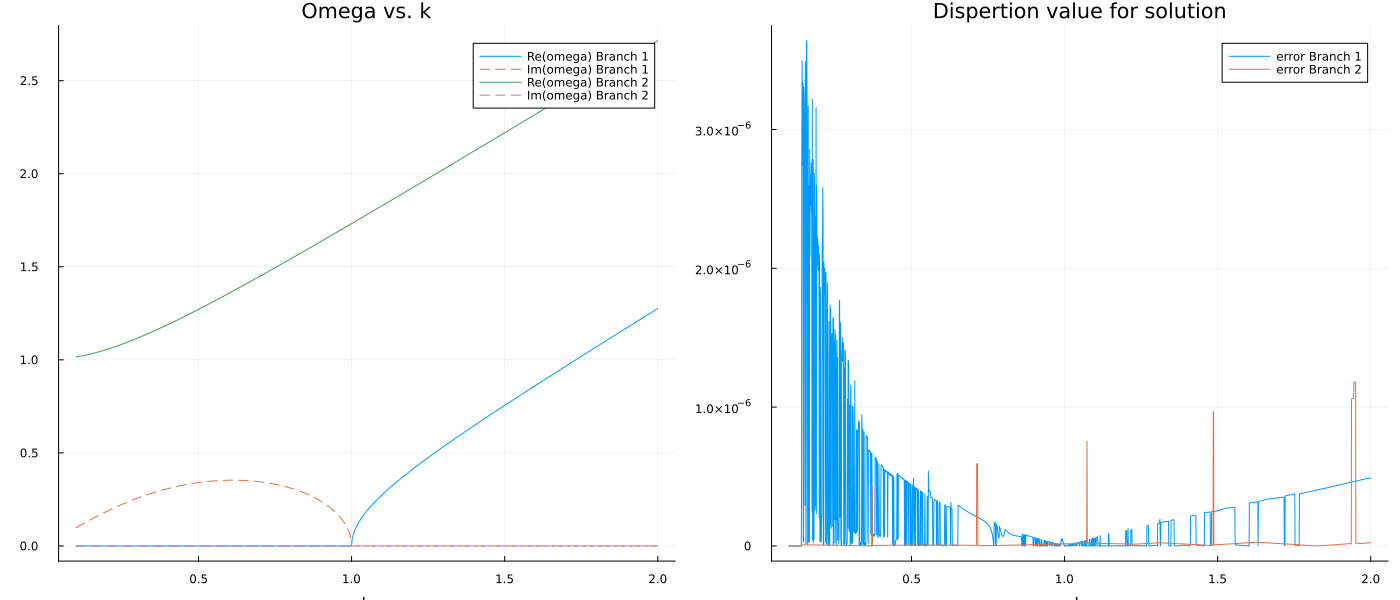

In [105]:
arg_static = ( V_0, omega_e)

initial_guesses = cold_electron_branches



branches_cold_elec = find_branch_solutions(function_wrapper_cold_elec,cold_elec_dispertion_relation_derivative , arg_static,  k_vals, initial_guesses, search_type=1, max_iterations=300, branch_step=1e-2, k_cut=0.2, large_k_diff_remove=0.2)

plot_branches(branches_cold_elec)


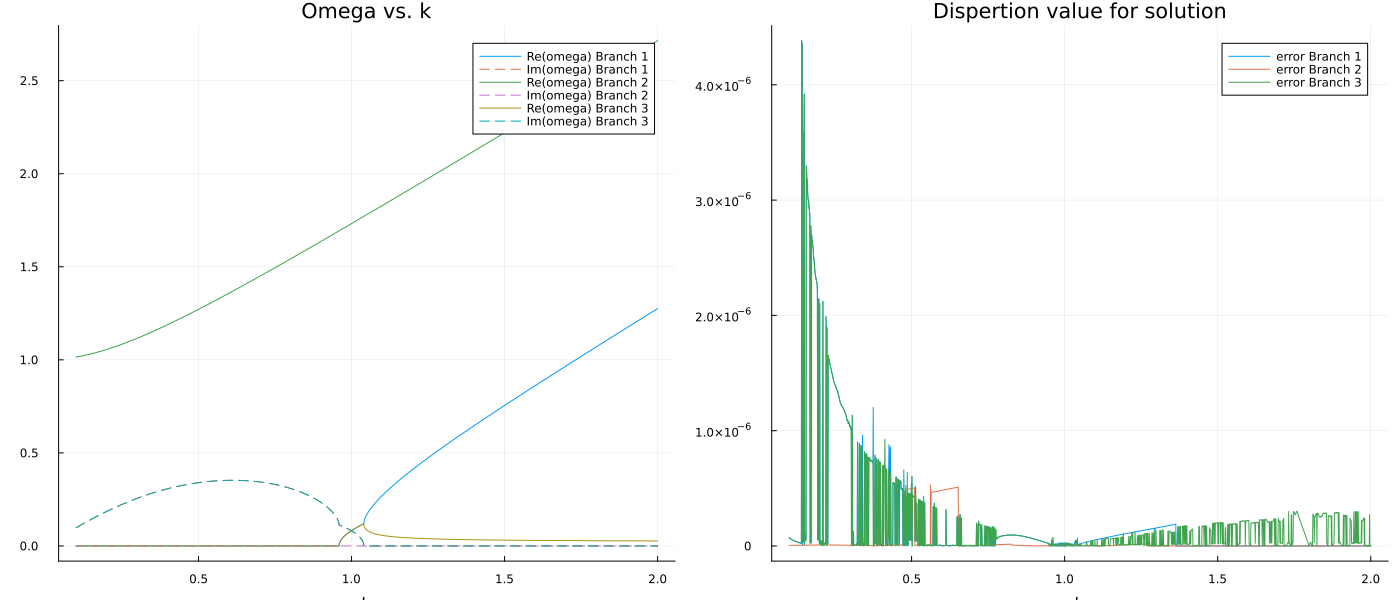

In [95]:
#branches = [[]]
arg_static = ( V_0, omega_e, omega_p)
#initial_guesses = sol_cold1 #[sol_cold1, sol_cold2]
#initial_guesses = [sol_cold1, sol_cold2]

initial_guesses = cold_electron_branches

#branches_cold_full = find_branch_solutions(function_wrapper_cold_full,cold_dispertion_relation_derivative, arg_static,  k_vals, initial_guesses, 300,1e-3,0.6,0.1)


branches_cold_full1 = find_branch_solutions(function_wrapper_cold_full,cold_dispertion_relation_derivative , arg_static,  k_vals, initial_guesses, search_type=1, max_iterations=300, branch_step=1e-3, k_cut=0.2, large_k_diff_remove=0.2)
branches_cold_full2 = find_branch_solutions(function_wrapper_cold_full,cold_dispertion_relation_derivative , arg_static,  k_vals, initial_guesses, search_type=2, max_iterations=300, branch_step=1e-3, k_cut=0.2, large_k_diff_remove=0.2)

#branches_cold_full = remove_negative_branches(branches_cold_full)

branches_cold_full = vcat(branches_cold_full1, [branches_cold_full2[1]])

plot_branches(branches_cold_full)

In [81]:

ks = [branches_cold_full[1][i][2] for i in 1:size(branches_cold_full[1],1)]
res = [branches_cold_full[1][i][1] for i in 1:size(branches_cold_full[1],1)]


k_max_index = argmax(imag.(res))
k_max = k_vals[k_max_index] 
omega_max = res[k_max_index]
omega_max_scales = omega_max / omega_e

println("Full cold-case")
println("K range             = ", k_vals[1], " ", k_vals[end])
println("K_max               = ", k_max)
println("k_max / 2pi         = ", k_max / (2*pi))
println("omega_max           = ", omega_max)
println("omega_max / omega_e = ", omega_max_scales)

Full cold-case
K range             = 0.5 10.0
K_max               = 3.056778389194597
k_max / 2pi         = 0.4865013905768016
omega_max           = -1.3755921852388868e-11 + 0.3527822359021211im
omega_max / omega_e = -1.3755921852388868e-11 + 0.3527822359021211im


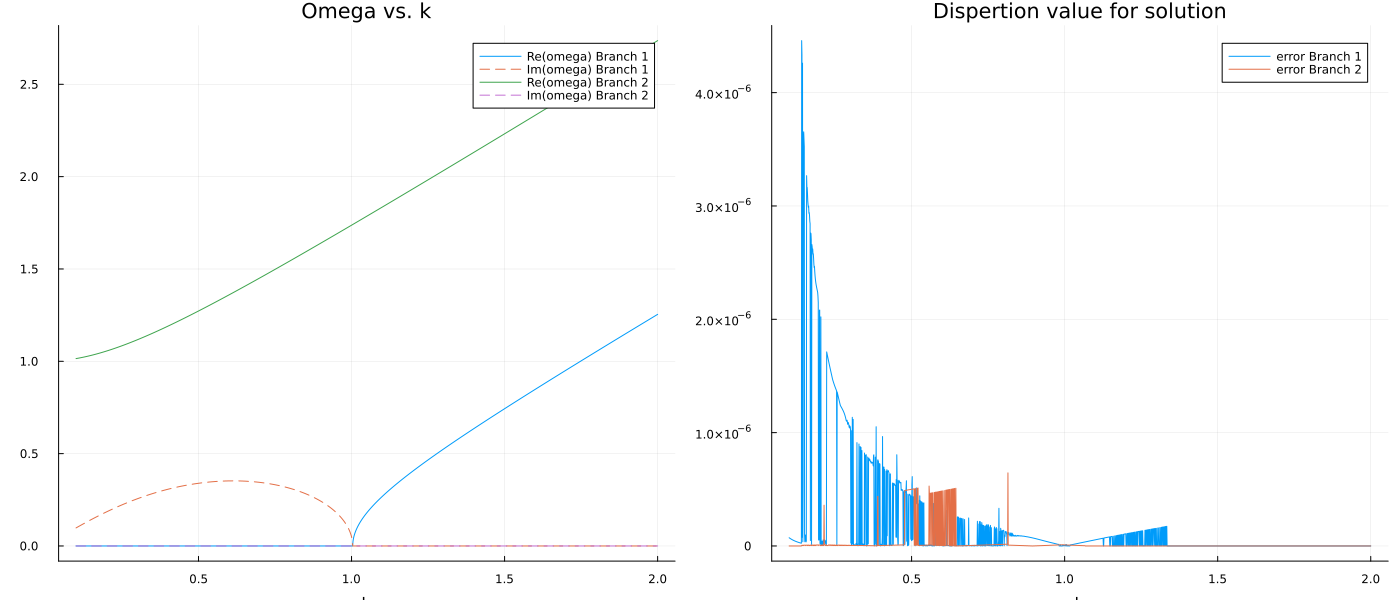

In [82]:
arg_static = (V_0, v_t_e, debye_e)
#initial_guesses = branches_cold_full
#initial_guesses = branches_cold_full

initial_guesses = branches_cold_elec


branches_warm_elec = find_branch_solutions(function_wrapper_warm_elec,warm_elec_dispertion_derivative , arg_static,  k_vals, initial_guesses, search_type=1, max_iterations=300, branch_step=1e-3, k_cut=0.2, large_k_diff_remove=0.2)

plot_branches(branches_warm_elec)

In [83]:

ks = [branches_warm_elec[1][i][2] for i in 1:size(branches_warm_elec[1],1)]
res = [branches_warm_elec[1][i][1] for i in 1:size(branches_warm_elec[1],1)]


k_max_index = argmax(imag.(res))
k_max = k_vals[k_max_index] 
omega_max = res[k_max_index]
omega_max_scales = omega_max / omega_e

println("K range             = ", k_vals[1], " ", k_vals[end])
println("K_max               = ", k_max)
println("k_max / 2pi         = ", k_max / (2*pi))
println("omega_max           = ", omega_max)
println("omega_max / omega_e = ", omega_max_scales)

K range             = 0.5 10.0
K_max               = 3.066283141570785
k_max / 2pi         = 0.48801411890033636
omega_max           = -4.2351299503368995e-12 + 0.35254860383052944im
omega_max / omega_e = -4.2351299503368995e-12 + 0.35254860383052944im


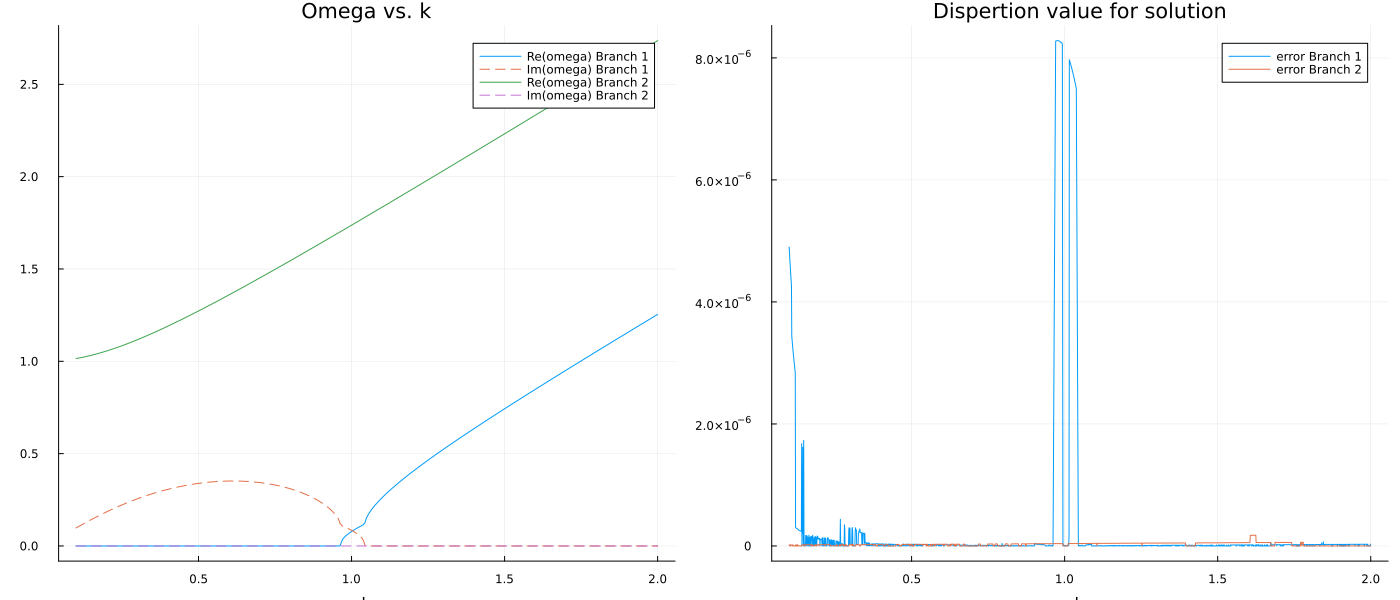

In [109]:
arg_static = (V_0, v_t_e, v_t_p, debye_e, debye_i)
initial_guesses = branches_cold_full
#initial_guesses = branches_warm_elec

branches_warm_full = find_branch_solutions(function_wrapper_warm_full,full_dispertion_relation_derivative , arg_static,  k_vals, initial_guesses, search_type=2, max_iterations=500, branch_step=1e-2, k_cut=0.2, large_k_diff_remove=0.2)

plot_branches(branches_warm_full[1:2])


In [103]:

ks = [branches_warm_full[1][i][2] for i in 1:size(branches_warm_full[1],1)]
res = [branches_warm_full[1][i][1] for i in 1:size(branches_warm_full[1],1)]


k_max_index = argmax(imag.(res))
k_max = k_vals[k_max_index] 
omega_max = res[k_max_index]
omega_max_scales = omega_max / omega_e

println("Full warm case")
println("K range             = ", k_vals[1], " ", k_vals[end])
println("K_max               = ", k_max)
println("k_max / 2pi         = ", k_max / (2*pi))
println("omega_max           = ", omega_max)
println("omega_max / omega_e = ", omega_max_scales)

Full warm case
K range             = 0.5 10.0
K_max               = 3.061530765382691
k_max / 2pi         = 0.48725775473856897
omega_max           = 1.4334417702476738e-9 + 0.3517755799956433im
omega_max / omega_e = 1.4334417702476738e-9 + 0.3517755799956433im


In [ ]:
k_cold = sqrt(3/8) * omega_e / V_0

In [ ]:
# Shift in growth rate for v_thermal = 0.05*V_0
growth_rate_shift = (0.351775579993647 -  0.3535533859335106) /  0.3535533859335106

#shifht in k for the same 
k_shifht = (3.061530765382691 - k_cold) / k_cold

println(growth_rate_shift)
println(k_shifht)

println("")
println(growth_rate_max)

In [ ]:
# Shift in growth rate for v_thermal = 0.05*V_0
growth_rate_shift = (0.3390310884727218 -  0.3535533859335106) /  0.3535533859335106
growth_rate_max  = (0.3486274017106596 -  0.3535533859335106) /  0.3535533859335106

#shifht in k for the same 
k_shifht = (2.586293146573287 - k_cold) / k_cold

println(growth_rate_shift)
println(k_shifht)

println("")
println(growth_rate_max)

In [ ]:
(2.586293146573287 - k_cold) / k_cold

In [ ]:
k_vals[540]

In [ ]:
temp_scale = 1.2

v_t_e_new = v_t_e * temp_scale
v_t_p_new =  v_t_p*temp_scale
debye_e_new = v_t_e_new / omega_e
debye_i_new = v_t_p_new / omega_p

arg_static = (V_0 , v_t_e_new, v_t_p_new, debye_e_new, debye_i_new)
#initial_guesses = branches_cold_full
#initial_guesses = branches_warm_full[1:3]
initial_guesses = branches_warm_full

branches_warm_full_v02 = find_branch_solutions(function_wrapper_warm_full, arg_static,  k_vals, initial_guesses, 300, 1e-5,5e-2,40)
plot_branches(branches_warm_full_v02)
